In [1]:
#Access Drive
#from google.colab import drive
#drive.mount('/content/drive/')

import h5py
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from tensorflow import keras

# python code to visualize
import sys
sys.path.append("D:\Akhilesh_PHD\Brain\BraTS_2020_New1")
import visualize
import losses_and_metrics as lnm
import custom_data_generator as data_gen



In [5]:
#HOME_DIR = "/content/drive/My Drive/Thesis_Experiment/BraTS_Dataset/"
processed_dir = "D:\Akhilesh_PHD\Brain\BraTS_2020_New1\Group_Normalization\\h5_dataset_GN_BraTs20200"

In [7]:
loaded_model = keras.models.load_model("D:\Akhilesh_PHD\Brain\BraTS_2020_New1\Group_Normalization\\h5_dataset_GN_BraTs2020\model-1_entire_state_GN_100_1", 
                                              custom_objects={'soft_dice_loss': lnm.soft_dice_loss, 
                                                              'dice_coefficient': lnm.dice_coefficient})

In [9]:
validated_on = "D:\Akhilesh_PHD\Brain\BraTS_2020_New1\Group_Normalization\\h5_dataset_GN_BraTs2020\\valid\BRATS_301.nii.gz_25x_24y_82z.h5"

with h5py.File(validated_on, 'r') as f:
    raw_data_valid = np.array(f.get('x'))
    raw_label_valid = np.array(f.get('y'))

In [10]:

raw_data_with_batch_dimension_valid = np.expand_dims(raw_data_valid, axis=0)
patch_pred_valid = loaded_model.predict(raw_data_with_batch_dimension_valid)

# set threshold
threshold = 0.5     #ideal 0.5

# use threshold to get hard predictions

patch_pred_valid[patch_pred_valid > threshold] = 1.0
patch_pred_valid[patch_pred_valid <= threshold] = 0.0

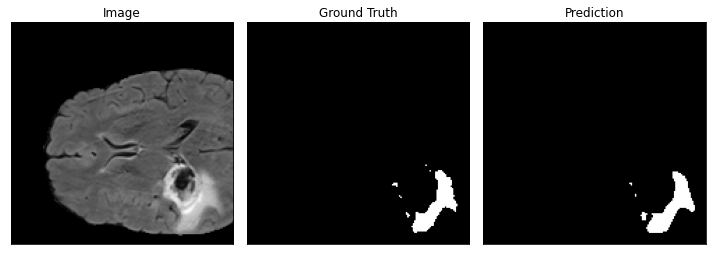

In [14]:
visualize.visualize_patch_predict(raw_data_valid[0, :, :, :], 
                                  raw_label_valid[:, :, :, 2], 
                                  patch_pred_valid[0, 1, :, :, :])
plt.tight_layout()
plt.show()

# Sensitivity and Specificity

In [15]:
def compute_class_perf(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.

    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.

    """

    # extract sub-array for specified class
    class_pred = pred[class_num]
    class_label = label[class_num]
    
    # compute:
    
    # true positives
    tp = np.sum((class_label == 1) & (class_pred == 1))
    
    # true negatives
    tn = np.sum((class_label == 0) & (class_pred == 0))
    
    #false positives
    fp = np.sum((class_label == 0) & (class_pred == 1))
    
    # false negatives
    fn = np.sum((class_label == 1) & (class_pred == 0))

    # compute pm
    Sensitivity = tp / (tp + fn)
    Specificity = tn / (tn + fp)
    #TPR = Recall = Sensitivity
    FPR = 1 - Specificity
    Precision = tp / (tp + fp)
    Dice_Score = (2*Precision*Sensitivity) / (Precision + Sensitivity)
    JAC = tp / (tp + fp + fn)

    return Sensitivity, Specificity, FPR, Dice_Score, JAC

def get_perf_df(pred, label):
    patch_metrics = pd.DataFrame(columns = ['Edema',
                                            'Non-Enhancing Tumor',
                                            'Enhancing Tumor'],
                                 index = ['Sensitivity', 'Specificity', 'FPR', 'Dice_Score', 'JAC'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec, fpr, dice, jac = compute_class_perf(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)
        patch_metrics.loc['FPR', class_name] = round(fpr,4)
        patch_metrics.loc['Dice_Score', class_name] = round(dice,4)
        patch_metrics.loc['JAC', class_name] = round(jac,4)

    return patch_metrics

In [16]:
print(raw_label_valid.shape)
raw_label_valid = np.moveaxis(raw_label_valid, -1, 0)
raw_label_valid = raw_label_valid[1:, :, :, :]
print(raw_label_valid.shape)
df = get_perf_df(patch_pred_valid[0], raw_label_valid)

print(df)

(160, 160, 16, 4)
(3, 160, 160, 16)
              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.7323              0.9308            0.94
Specificity  0.9998              0.9937          0.9969
FPR          0.0002              0.0063          0.0031
Dice_Score   0.8366               0.887           0.866
JAC          0.7191              0.7969          0.7637
